# Flight Delay Analysis

**A Study of Alaska Airlines AS306 SEA-SFO**

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data Preparation

In [2]:
# Import data
df = pd.read_csv("flight-delays/flights.csv", low_memory=False)

In [3]:
ts = df[(df['AIRLINE'] == 'AS') & (df['FLIGHT_NUMBER'] == 306)]
ts = ts[(ts['ORIGIN_AIRPORT'] == 'SEA') | (ts['ORIGIN_AIRPORT'] == '14747')]
ts['DATE'] = pd.to_datetime(ts[['YEAR','MONTH', 'DAY']])
ts = ts.set_index('DATE')
ts = ts[['DEPARTURE_DELAY','ARRIVAL_DELAY','ELAPSED_TIME']]
ts.head()

,DEPARTURE_DELAY,ARRIVAL_DELAY,ELAPSED_TIME
DATE,,,
2015-01-01,108.0,96.0,112.0
2015-01-02,-5.0,-9.0,120.0
2015-01-03,30.0,32.0,126.0
2015-01-04,53.0,40.0,111.0
2015-01-05,16.0,13.0,121.0


In [4]:
# Data Profiling
m = len(ts)
print('---%s Data Points---' %m)
dp = ts.isnull().sum(axis=0).reset_index()
dp.columns = ['Series', 'NaN']
dp

---365 Data Points---


,Series,NaN
0,DEPARTURE_DELAY,0
1,ARRIVAL_DELAY,1
2,ELAPSED_TIME,1


In [5]:
# Impute missing value by Backward Fill
ts = ts.bfill()

## Data Exploration

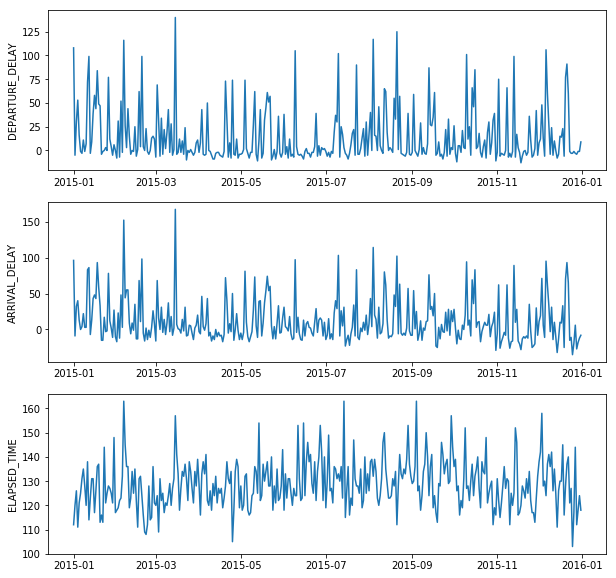

In [6]:
# Visualize time series
plt.figure(figsize=(10,10))
for i, s in enumerate(ts):
    ax = plt.subplot(3, 1, i+1)
    ax.plot(ts.index,ts[s])
    ax.set_ylabel(s)

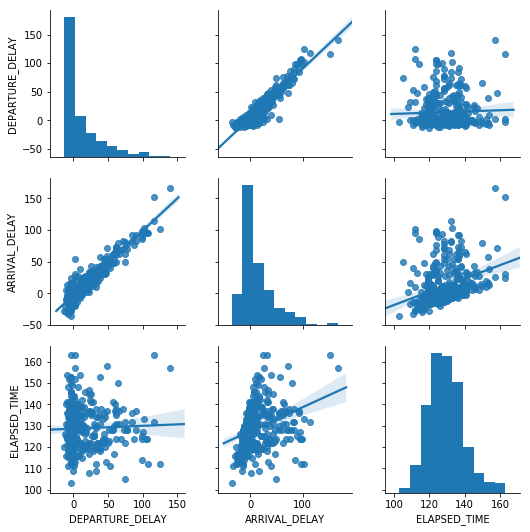

In [7]:
# Explore relationships
sns.pairplot(ts, kind="reg")

## Exponential Smoothing Model

A basic exponential smoothing time series model `ARIMA(p=0,d=1,q=1)`

Let $S_t$ denotes the expected baseline and $x_t$ denotes the observed actual at time period $t$,

Basic model equation:
$$
\begin{aligned}
S_0 &= x_0 \\
S_t &= \alpha x_t +(1−\alpha)S_{t−1}, t>0
\end{aligned}
$$

Forecast for $t+1$:
$$
F_{t+1}=S_t
$$

In [8]:
class ExpSmooth(object): 
    def __init__(self,x): 
        self._x = x
        self._m = len(x)
        
    def fit(self,alpha=.25):
        S = self._x.copy()
        for i in range(1, self._m):
            S[i] = alpha*self._x[i] + (1-alpha)*S[i-1]
        return S

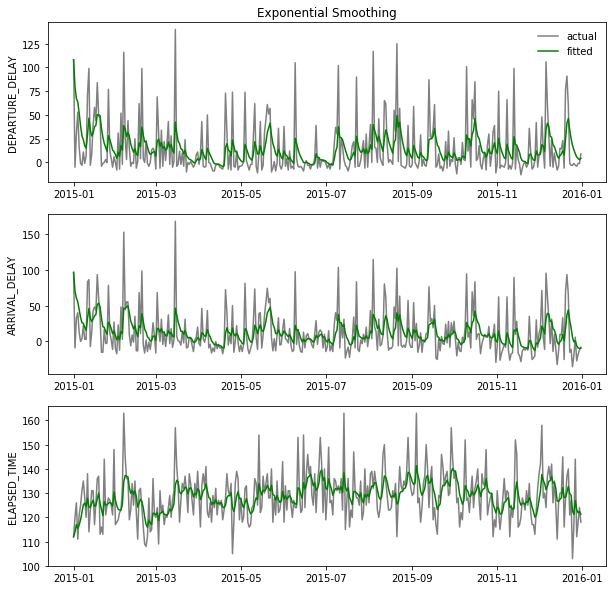

In [9]:
plt.figure(figsize=(10,10))
for i, s in enumerate(ts):
    model = ExpSmooth(np.asarray(ts[s]))
    fit = model.fit()
    
    ax = plt.subplot(3, 1, i+1)
    ax.plot(ts.index, ts[s], color="grey", label="actual")
    ax.plot(ts.index, fit, color='g', label="fitted")
    ax.set_ylabel(s)
    
    if i == 0:
        ax.legend(loc=1,frameon=False)
        ax.set_title("Exponential Smoothing") 

**Conclusion:** It looks like there is a lot of randomness in flight delay, as observed from the frequent spikes.

## Linear Regression Model

Given the strong correlation between `DEPARTURE_DELAY` and `ARRIVAL_DELAY`, a simple linear model is implemented to predict `ARRIVAL_DELAY` $y_i$ using `DEPARTURE_DELAY` $x_i$. 

$$
y_i = w_0 + w_1 x_i + \epsilon
$$

A gradient descent optimization routine is demonstrated using the least squares approach.

Loss Function (Mean Squared Error):
$$
\mathcal{L}(y,X,w) = \dfrac{1}{m} \sum_{i=1}^{m} (y_i- w^Tx_i)^2
$$

Gradient:
$$
\dfrac{\partial\mathcal{L}(y,X,w)}{\partial w} = -\dfrac{1}{m} \sum_{i=1}^{m} 2x_i(y_i - w^Tx_i)\\
$$

In [10]:
data = ts.values
x = data[:,0].reshape(m,1)
y = data[:,1]

In [11]:
class LinReg(object): 
    def __init__(self): 
        pass
        
    def fit(self,X,y):
        m,n = X.shape
        X1 = np.ones((m,n+1))
        X1[:,:-1] = X
        w = np.ones(n+1)
        learning_rate = 1e-6
        tolerance = 1e-6
        max_iter = 1000
        i = 0
        converged = False
        while ((not converged) and (i < max_iter)):
            # Calculate the gradient
            dw = -X1.T.dot(y-X1.dot(w))
            # Update w
            new = w - learning_rate * dw
            converged = (np.sum(np.abs(new-w)) < tolerance)
            w = new
            i += 1
            # Calculate loss function
            error = y - X1.dot(new)
            mse = error.T.dot(error)/m
            #print(mse)
        self.beta_ = w    
        self.coef_ = w[:-1]
        self.intercept_ = w[-1]
        return self
    
    def predict(self,X):
        m,n = X.shape
        X1 = np.ones((m,n+1))
        X1[:,:-1] = X
        return X1.dot(self.beta_)
    
    def score(self, X, y):
        y_hat = self.predict(X)
        y_bar = np.mean(y)
        rss = np.square(y - y_hat).sum()
        tss = np.square(y - y_bar).sum()
        return 1 - rss/tss

In [12]:
model = LinReg().fit(x,y)
print('R-Square: %.2f' %model.score(x, y))
print('Coef: ', model.coef_)
print('Intercept: %.2f' %model.intercept_)

R-Square: 0.88
Coef:  [0.98123108]
Intercept: 0.12


**Conclusion:** `ARRIVAL_DELAY` $y_i$ can be well predicted by `DEPARTURE_DELAY` $x_i$ using the linear model below

$$
\hat{y_i} = 0.12 + 0.98 x_i
$$

Intuitively, flight arrival delay is mostly caused by delay during departure.